# Introduction

## William Koehrsen wjk68

In this notebook we examine using the implementation of Independent Component Analysis for separating mixed audio signals. Indepedent component analysis (ICA) finds the sparse, independent components in a signal under the assumption that the signal is a linear combination of non-Gaussian components. ICA can be used for both blind source separation, such as in this project, and dimensionality reduction. We will verify the FastICA method developed in a previous notebook using synthetic Laplacian data with a known mixing matrix. Then we will attempt to separate out the sources and the mixing matrix for an audio signal composed of two separate samples mixed with a random mixing matrix. 

The general equation governing ICA is that the signal is a linear combination of samples:

$$X = AS$$

where X, the signal, is the product of the mixing matrix, A, and the sample matrix, S. The objective is to separate out the indepedent samples and the estimated mixing matrix. The specific implementation of ICA used in this project is [FastICA](https://www.cs.helsinki.fi/u/ahyvarin/papers/TNN99new.pdf) which has numerous advantages over gradient-based methods. The utility function used in FastICA is [Negentropy](https://www.cs.helsinki.fi/u/ahyvarin/papers/TR_A47_apprent.pdf), which is a measure of the non-Gaussianity of a distribution. The objective is to maximize the negentropy of the independent components given the data.

We will inspect the mixing matrix and indentified sources both visually and quantitatively to determine if the implementation of ICA is working correctly. We expect that for a signal composed of a linear combination of non-Gaussian components, the ICA algorithm should be able to separate out the sparse, independent components. 

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

In [2]:
# Matploblit and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Scipy io used for audio file management
from scipy.io import wavfile

# Scipy stats.mstats used for testing distributions
from scipy.stats.mstats import normaltest, skewtest, kurtosistest

## Import FastICA Algorithm

In [3]:
# Import algorithm developed in previous notebook
from parallel_ica import perform_fastica

## Functions from Demo

A number of functions were developed in the demo, primarily to help with processing the audio data and drawing mixing matrices. We will use these functions with a few minor modifications of the plotting format. 

In [31]:
# Normalize audio amplitude between -0.5 and 0.5
def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

# Mix a matrix of samples using a random mixing matrix
def simpleMixer(S):
    # Set seed for consistent runs
    np.random.seed(42)
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

# Plot the mixed signal with the mixing matrix
def drawDataWithMixingMatrix(data, mat, ground_truth=True):
    plt.figure(figsize=(8, 6))
    # plot data points
    plt.scatter(data[0], data[1], s=2, alpha = 0.6)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')
    if ground_truth:
        plt.title('Data with True Mixing Matrix', size = 18)
    else:
        plt.title('Data with Estimated Mixing Matrix', size = 18)
    
# Show mixed signal with true mixing matrix and estimated mixing matrix
def compareMixingMatrix(data, matA, matB):
    # plot first mixing matrix
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    drawDataWithMixingMatrix(data, matB, ground_truth=False)

### Read in Audio Data and Visualize

The first audio sample is a piece of Bach music while the second is a snippet of speech. The audio files are normed between [-0.5, 0.5] and plotted below. We can see that each sample is slightly more than 120,000 separate points, with each point representing an amplitude. 

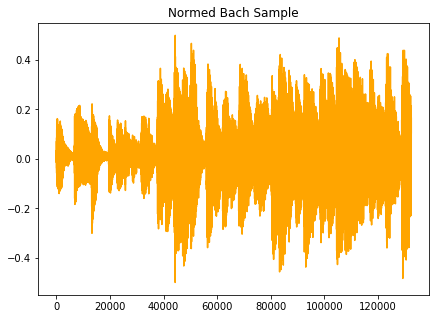

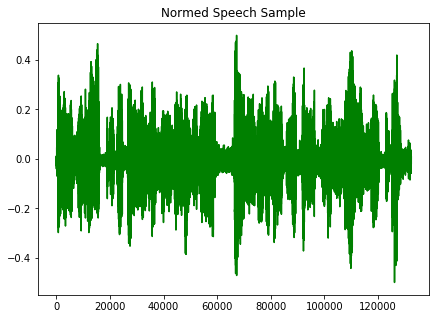

In [34]:
# Bach Audio
srate, bach_sample = wavfile.read('../data/bach.wav')
bach_sample = audionorm(bach_sample)
plt.figure(figsize=(7, 5))
plt.plot(bach_sample, color = 'orange')
plt.title('Normed Bach Sample');
plt.show();


# Speech audio
_, speech_sample = wavfile.read('../data/speech.wav')
speech_sample = audionorm(speech_sample)
plt.figure(figsize=(7, 5))
plt.plot(speech_sample, color = 'green')
plt.title('Normed Speech Sample');
plt.show();


# Check Gaussianity of Audio Data

Independent component analysis works on the assumption that the components of a signal are non-Gaussian. To test this, we can calculate the skew and kurtosis as well as the D'Agostino and Pearson's Test that combines the two measures to arrive at a single omnibus estimate for Gaussianity of the data. We will use [`scipy.stats.mstats.normaltest`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mstats.normaltest.html) which tests the Null Hypothesis that the sample is from a Gaussian distribution. If the p-value is less than 0.05, we can reject the null hypothesis, and conclude there is evidence to prove that the data is not Gaussian. We can also plot the histogram of the data along with a Gaussian and Laplacian distribution of the same size for a visualize comparison. 

The normal test calculates the $k2$ measures defined as $k2 = s^2 + k^2$ where s is the skew of the distribution and k is the kurtosis. The test for normality was developed by D'Agostino and Pearson
"D’Agostino, R. and Pearson, E. S. (1973), “Testing for departures from normality,” Biometrika, 60, 613-622". To get a sense of the skew and kurtosis measures, we can calculate them for the signal, a Gaussian distribution, and a Laplacian distribution. Combining the visual with the quantitative stats is a helpful way to think through concepts.

In [35]:
def check_gaussianity(X):
    # Perform D'Agostino and Pearson's test to determine normality
    # Combines skew and kurtosis for combined test of normality
    # k2 = s^2 + k^2 where s is skew and k is kurtosis
    test_result = normaltest(X)
    print('Normal Test p-value = {:0.4f}'.format(test_result.pvalue))
    
    # Calculate actual skew and kurtosis
    skew = skewtest(X).statistic
    kurtosis = kurtosistest(X).statistic
    
    # Find Gaussian and Laplacian Distributions of same length
    gaussian = np.random.randn(len(X))
    laplacian = np.random.laplace(size = len(X))
    
    # Interpret p-value
    if test_result.pvalue < 0.05:
        print('Reject Null Hypothesis that sample comes'
              ' from a normal distribution at alpha = 0.05')
    else:
        print('Fail to reject Null Hypothesis that sample'
              ' comes from a normal distribution at alpha= 0.05')
        
        
    print('\nSample Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}'.format(skew, kurtosis))
    
    print('Gaussian Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}'.format(skewtest(gaussian).statistic, 
                                            kurtosistest(gaussian).statistic))
    print('Laplacian Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}\n'.format(skewtest(laplacian).statistic, 
                                            kurtosistest(laplacian).statistic))
    
    
    plt.figure(figsize=(16, 8))
    
    # Plot sample distribution
    plt.subplot(131)
    sns.distplot(X, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 14); plt.ylabel('Density', size = 14);
    plt.title('Sample Distribution', size = 18);
    
    # Plot Gaussian Distribution of same length
    plt.subplot(132)
    sns.distplot(gaussian, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 14); plt.ylabel('Density', size = 14);
    plt.title('Gaussian Distribution', size = 18);
    
    # Plot laplace
    plt.subplot(133)
    sns.distplot(laplacian, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 18); plt.ylabel('Density', size = 18);
    plt.title('Laplacian Distribution', size = 18);
    
    plt.show();
    

## Test Check Gaussianity Function

First, we will just check the Gaussianity testing function on a dataset that we know is Gaussian, one generated by `np.random.randn`. The p-value should be much greater than 0.05, indicating that we should fail to reject the null hypothesis that the data is from a Gaussian distribution.

Normal Test p-value = 0.7808
Fail to reject Null Hypothesis that sample comes from a normal distribution at alpha= 0.05

Sample Distribution Skew = 0.7034  Kurtosis = 0.0086
Gaussian Distribution Skew = 1.3618  Kurtosis = -0.5732
Laplacian Distribution Skew = -1.7622  Kurtosis = 100.6958



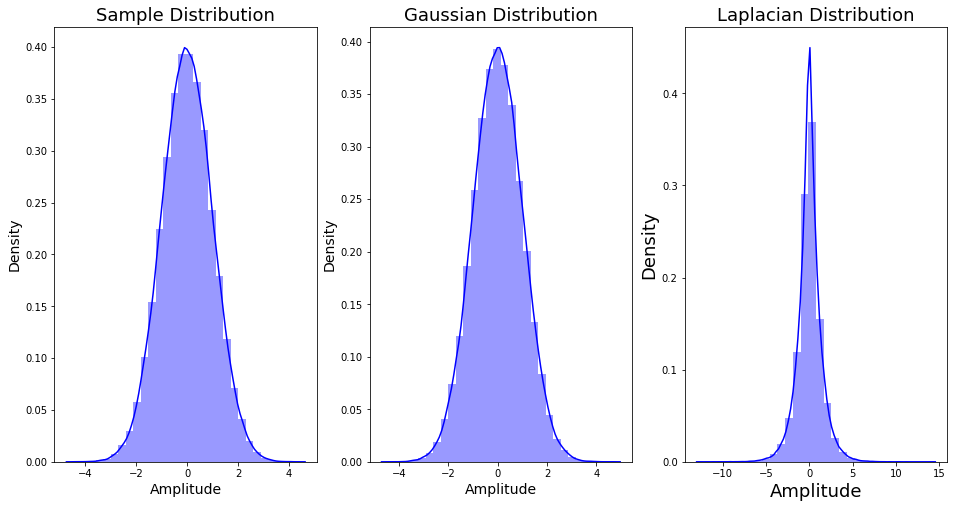

In [36]:
check_gaussianity(np.random.randn(len(bach_sample)))

The check Gaussianity function clearly identifies that this is a Gaussian Distribution. 

## Test Bach Audio Sample

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = -9.9593  Kurtosis = 41.7558
Gaussian Distribution Skew = -1.5662  Kurtosis = 0.3264
Laplacian Distribution Skew = -7.8348  Kurtosis = 95.4612



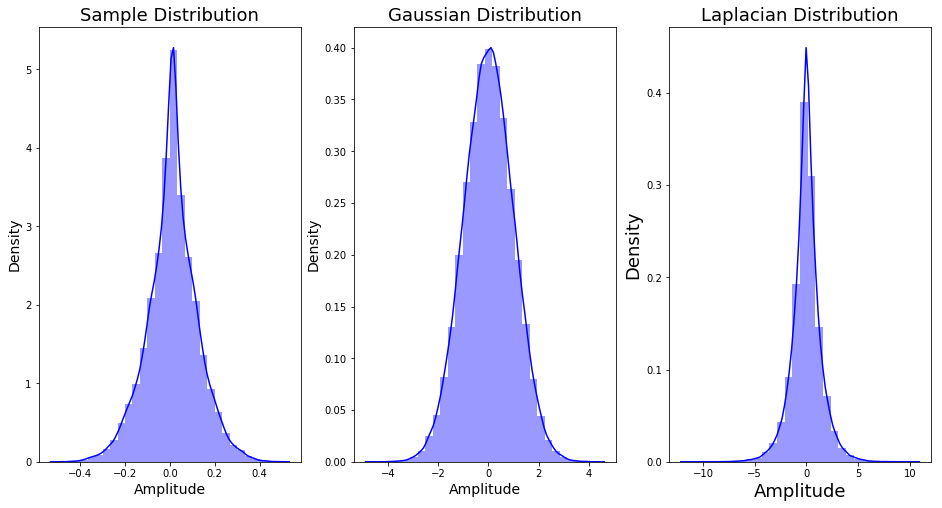

In [37]:
check_gaussianity(bach_sample)

From the test results, we fail to reject the null hypothesis that the Bach audio sample is from a normal distribution. Therefore, we can be confident that this data is not Gaussian. It also appears that the Bach audio follows a Laplacian distribution due to the high Kurtosis ([this is also known as super-Gaussianity](https://en.wikipedia.org/wiki/Kurtosis)). A [Laplacian distribution](https://en.wikipedia.org/wiki/Laplace_distribution) has excess positive kurtosis and is called "leptokurtic". This distribution has a sharper peak and more weight in the tails than a standard Gaussian. A Laplacian Distribution is sparse, meaning that most of the values are concentrated at the mean with a few significant outliers, lending the distibution wider tails and a sharper peak than a Gaussian distribution.

## Test Speech Sample

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = 15.9990  Kurtosis = 84.8716
Gaussian Distribution Skew = -1.2445  Kurtosis = 0.2101
Laplacian Distribution Skew = 2.3461  Kurtosis = 96.9571



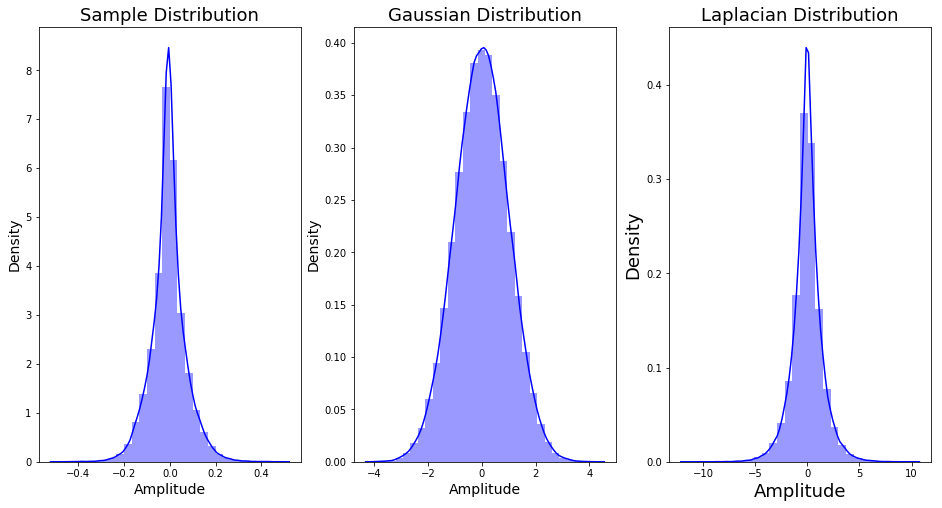

In [38]:
check_gaussianity(speech_sample)

The speech audio sample also does not follow a normal distribution from the results of the test. We can therefore move forward with attempting to separate out the samples from a linear combination of the two independent, non-Gaussian audio samples.

## Mix Bach and Speech Samples

The signal we will analyze is a linear combination of the two indepedent sources created by the equation

$$X = AS$$

X is the signal, A is the mixing matrix, and S is the matrix of sources. In this case, the sources are mixed together using a random mixing matrix. 

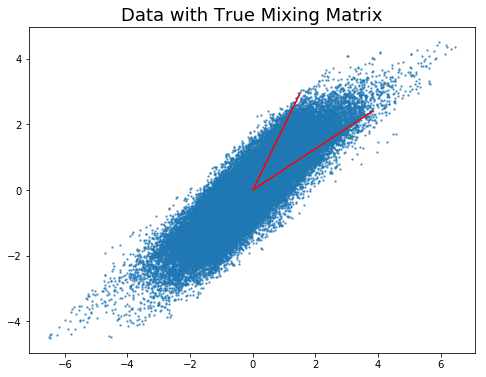

In [39]:
samples = audionorm([bach_sample, speech_sample])

# Standardize samples
samples = (samples.T / samples.std(axis=1)).T

# Mix samples in linear combination with random mixing matrix
X, true_A = simpleMixer(samples)

# Plot the mixed data
drawDataWithMixingMatrix(X, true_A)

## Visualize Samples and Mixed Signal

To get a sense of what the mixing matrix is doing, we can look at the individual samples and the combined signal. 

In [40]:
def plot_samples_mixed(samples, signal):
    # Independent Samples
    plt.figure(figsize=(8, 6))
    plt.plot(samples[0, :], label = 'Sample 1')
    plt.plot(samples[1, :], label = 'Sample 2')
    plt.legend()
    plt.title('Samples', size = 18)
    plt.show(); 
    
    # Mixed signal
    plt.figure(figsize=(8, 6))
    plt.plot(signal[0, :], alpha = 1.0, label = 'Mixed 1')
    plt.plot(signal[1, :], alpha = 1.0, label = 'Mixed 2')
    plt.legend()
    plt.title('Mixed Signal', size = 18)
    plt.show();

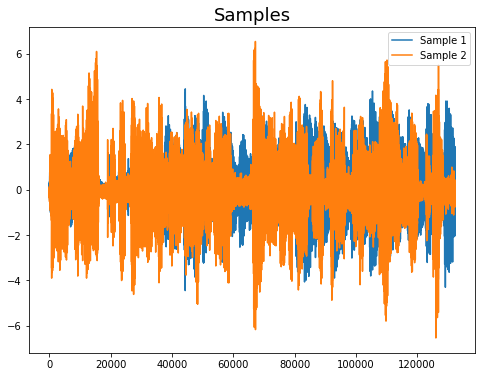

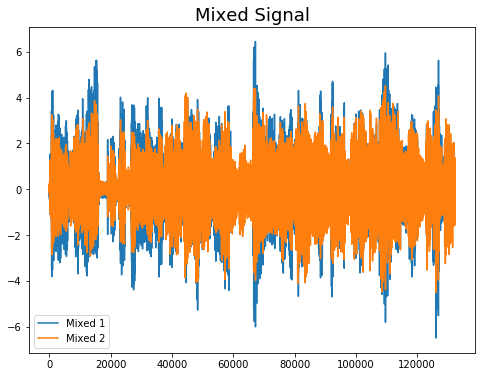

In [41]:
plot_samples_mixed(samples, X)

# Verify ICA Implementation

Before separating the audio sources, we will verify the ICA implementation using synthetic data. The data is generated from a Laplacian Distribution and combined with a defined mixing matrix so we know that the overall signal is a linear combination of non-Gaussian components and the ICA method should function very well on this data.

## Generate Synthetic Laplacian Data

In [45]:
# Generate a mixed signal for a number of samples and
# defined mixing matrix
def generate_laplacian_data(n_samples, mixing):
    # Set seed for reproducible results
    np.random.seed(seed = 50)
    
    # Laplacian distributions
    s1 = np.random.laplace(size = n_samples)
    s2 = np.random.laplace(size = n_samples)
    
    # Combine into one array
    S = np.array([s1, s2])
    
    # Mix samples
    generated_data = mixing.dot(S)
    
    return generated_data, S

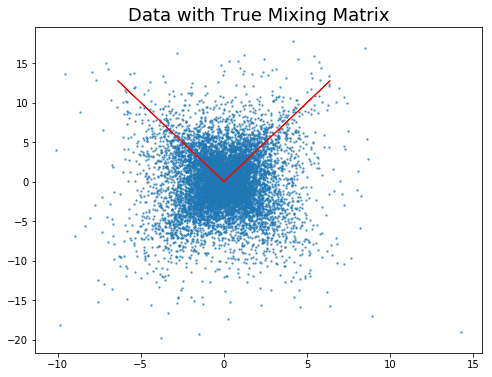

In [46]:
# Defined mixing matrix
verify_mixing = np.array([[-1, 1],
                          [2, 2]])

# Signal for verification
verify_signal, verify_samples = generate_laplacian_data(n_samples = 10000, mixing = verify_mixing)

# Visualize the verification data
drawDataWithMixingMatrix(verify_signal, verify_mixing)

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = -2.8428  Kurtosis = 26.3515
Gaussian Distribution Skew = -0.8293  Kurtosis = -0.4725
Laplacian Distribution Skew = 0.5005  Kurtosis = 28.1637



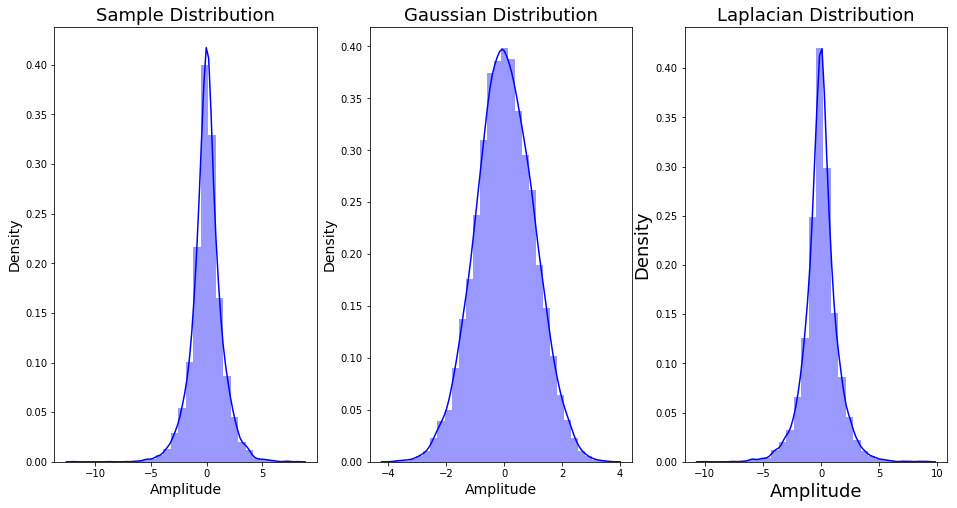

In [47]:
check_gaussianity(verify_samples[0, :])

### Visualize Generated Validation Data

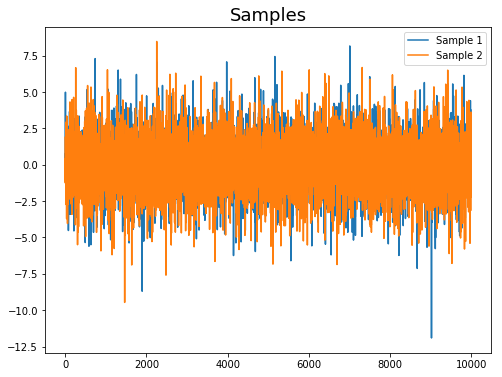

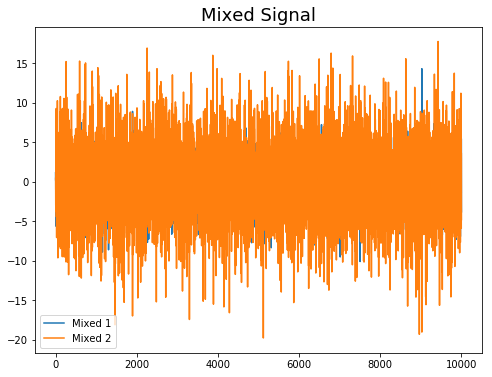

In [48]:
plot_samples_mixed(verify_samples, verify_signal)

## Implement ICA on Validation Data

In [49]:
# Use developed implementation of ICA, signal must be transposed
mixing, sources, mean = perform_fastica(verify_signal.T, n_components = 2, print_negentropy=True)

Iteration: 0 Increase in Negentropy: 0.0423.
Iteration: 1 Increase in Negentropy: 0.0085.
Iteration: 2 Increase in Negentropy: 0.0000.


## Examine Estimated Mixing Matrix

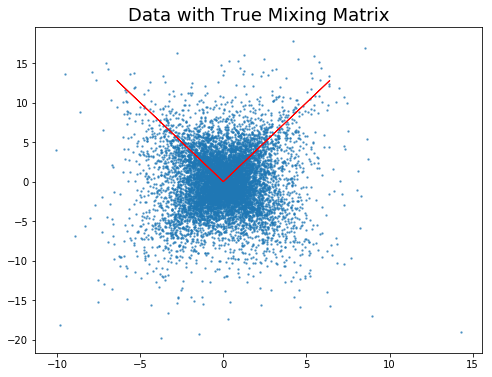

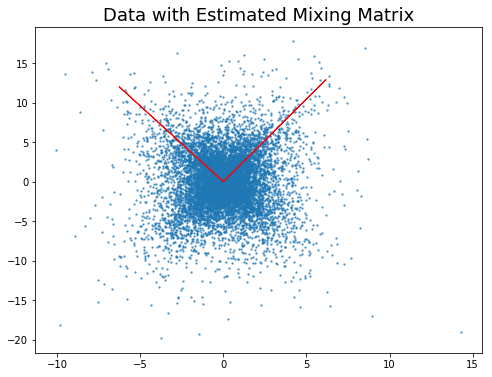

In [50]:
compareMixingMatrix(verify_signal, verify_mixing, mixing)

In [51]:
print('True Mixing Matrix\n')
print(verify_mixing)
print('\nEstimated Mixing Matrix\n')
print(mixing)

True Mixing Matrix

[[-1  1]
 [ 2  2]]

Estimated Mixing Matrix

[[ 138.34822884 -140.37567214]
 [ 289.40506692  269.28916873]]


Although the numbers in the mixing matrix are not the same, the independent components have been correctly identified. The [signs on the independent components](https://stats.stackexchange.com/questions/30348/is-it-acceptable-to-reverse-a-sign-of-a-principal-component-score) may be reversed from the actual values because the signs are arbitrary. Also, ICA is a non-deterministic algorithm, so the exact mixing matrix will vary every run. What we can see from the figure is that the FastICA method has identified the independent components.

## Examine Estimated Sources

We can also look at the estimated sources from ICA. These should be the same as the original within a sign change and a constant scaling factor. 

In [52]:
def plot_samples_estimates(samples, estimates):
    # Independent Samples
    plt.figure(figsize=(8, 6))
    plt.plot(samples[0, :], label = 'Sample 1')
    plt.plot(samples[1, :], label = 'Sample 2')
    plt.legend()
    plt.title('Ground Truth Samples', size = 18)
    plt.show(); 
    
    # Mixed signal
    plt.figure(figsize=(8, 6))
    plt.plot(estimates[0, :], alpha = 1.0, label = 'Mixed 1')
    plt.plot(estimates[1, :], alpha = 1.0, label = 'Mixed 2')
    plt.legend()
    plt.title('Estimated Samples', size = 18)
    plt.show();

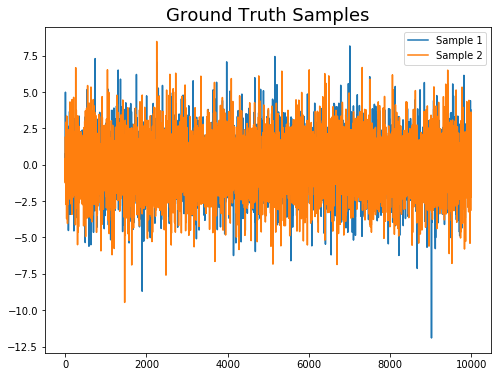

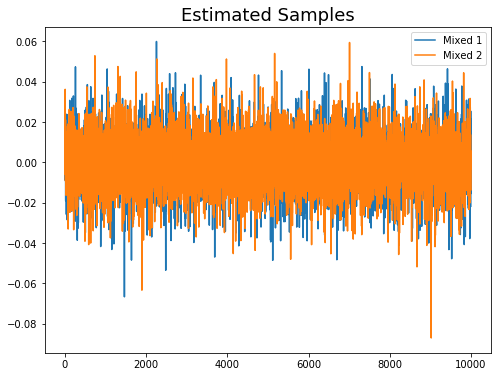

In [53]:
plot_samples_estimates(verify_samples, sources.T)

From the above visuals, we can be confident that our ICA implementation works on a signal that is a linear combination of non-Gaussian components. It is able to identify the mixing matrix and the original sources from which the signal is derived. 

# Test ICA on Audio Data

Now it's time to apply the FastICA implementation to the mixed audio samples. We should be able to find an appropriate mixing matrix and separate out the sources. 

In [54]:
audio_mixing, audio_sources, audio_mean = perform_fastica(X.T, n_components=2, print_negentropy=True)

Iteration: 0 Increase in Negentropy: 0.0078.
Iteration: 1 Increase in Negentropy: 0.0000.


## Visualize Actual and Estimated Mixing Matrices

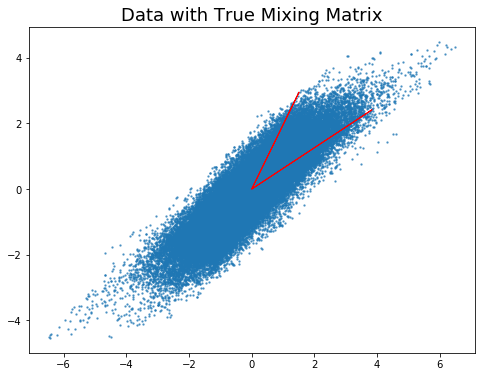

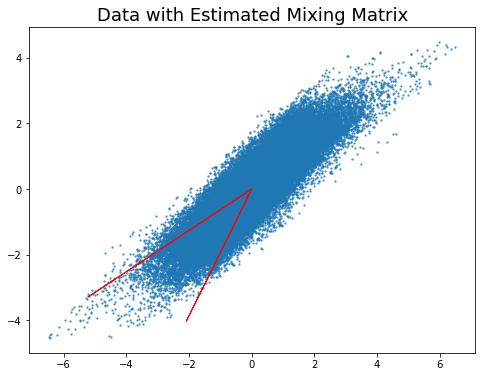

In [55]:
compareMixingMatrix(X, true_A, audio_mixing)

In [56]:
print('True Mixing Matrix\n')
print(true_A)
print('\nEstimated Mixing Matrix\n')
print(audio_mixing)

True Mixing Matrix

[[0.37454012 0.95071431]
 [0.73199394 0.59865848]]

Estimated Mixing Matrix

[[-345.98250801 -138.58964824]
 [-218.00245656 -267.77563995]]


As mentioned previously, the signs on the Independent Components are arbitrary. However, we can see that the algorithm was able to identify the independent components as seen in the mixing matrix. 

We also see from the printed information that the Negentropy of the independent components decreased over the iterations. The FastICA implementation maximizes the non-Gaussianity of the Independent Components.

## Visualize Actual and Estimated Sources

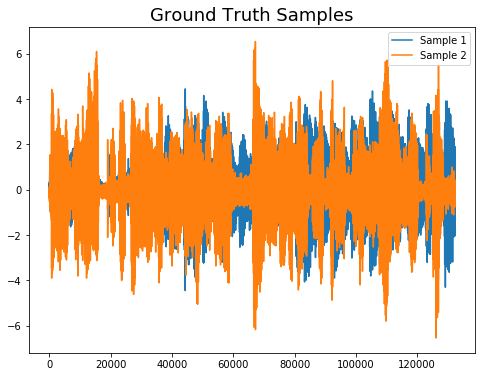

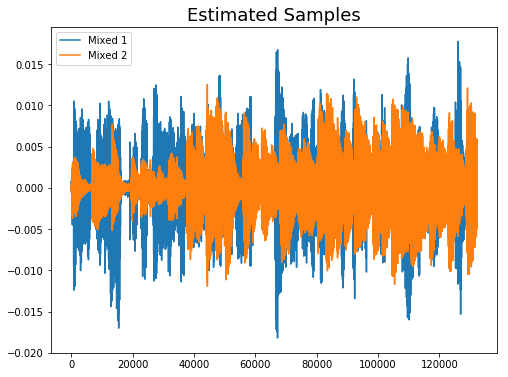

In [57]:
plot_samples_estimates(samples, audio_sources.T)

Again, we see that within a sign change and a constant scaling factor, the ICA method separated out the sources. Given the mixing matrix plot and the source plot, we can have confidence that our implementation is working as expected.

# Conclusions

In this notebook, we tested our developed implementation of Indepedent Component Analysis both on synthetic data and on audio samples. For both cases, the ICA method was able to identify the independent components as observed in the estimated mixing matrix and the sources. We did see that the mixing matrix does not have the same numbers as the original because there may be an [infinite number of solutions](http://people.wku.edu/david.neal/307/Unit2/LinearComb.pdf) for the mixing matrix because the signal is a linear combination of the sources ([a linear transformation gives either one, zero, or infinite solutions.](https://math.stackexchange.com/questions/204768/linear-combinations-and-solutions)) There will always be [ambiguity both in the mixing matrix and the sources from independent component analysis](http://cs229.stanford.edu/notes/cs229-notes11.pdf) because there is no method to recover the exact scaling of the independent sources. This answers a question from the previous notebook where we saw differences in sign changes and in scaling between the results and the known values. Overall, this assignment has demonstrated a fast implementation of Independent Component Analysis and verified its use in finding the sources in signals that are composed of linear combinations of non-Gaussian indepedent components. 